In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom

import pennylane as qml
from pennylane.operation import Operation

import qiskit
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeAuckland


In [2]:
def Avg1stFP(dA, dB, t):
    dA2 = dA ** 2.0
    F_haar = 1. / binom(dA, dA - 1)
    res = F_haar * dA2 * (dB + 1) / (dA2 * dB + 1)
    res += (dA - 1) * (dA * dB - 1) / (dA2 * dB + 1) * \
        ((dA2 - 1) * dB / (dA2 * dB ** 2. - 1)) ** t

    return res

## 1 Qubit

In [3]:
class Gen2QGate(Operation):
    num_wires = 2
    grad_method = None

    def __init__(self, weights, wires, id=None):
        super().__init__(weights, wires=wires, id=id)

    @property
    def num_params(self):
        return 1

    @staticmethod
    def compute_decomposition(weights, wires):
        wires = qml.wires.Wires(wires)
        op_list = []

        op_list.append(qml.RZ(weights[0], wires=wires[0]))
        op_list.append(qml.RY(weights[1], wires=wires[0]))
        op_list.append(qml.RZ(weights[2], wires=wires[0]))

        op_list.append(qml.RZ(weights[3], wires=wires[1]))
        op_list.append(qml.RY(weights[4], wires=wires[1]))
        op_list.append(qml.RZ(weights[5], wires=wires[1]))

        op_list.append(qml.CNOT(wires=wires))

        op_list.append(qml.RY(weights[6], wires=wires[0]))
        op_list.append(qml.RZ(weights[7], wires=wires[1]))

        op_list.append(qml.CNOT(wires=wires[::-1]))

        op_list.append(qml.RY(weights[8], wires=wires[0]))

        op_list.append(qml.CNOT(wires=wires))

        op_list.append(qml.RZ(weights[9], wires=wires[0]))
        op_list.append(qml.RY(weights[10], wires=wires[0]))
        op_list.append(qml.RZ(weights[11], wires=wires[0]))

        op_list.append(qml.RZ(weights[12], wires=wires[1]))
        op_list.append(qml.RY(weights[13], wires=wires[1]))
        op_list.append(qml.RZ(weights[14], wires=wires[1]))

        return op_list

In [4]:
n_wires = 4
dev = qml.device('default.qubit', wires=n_wires, shots=1000)

@qml.qnode(dev)
def qml_circuit(params):
    Gen2QGate(weights=params[0], wires=[0, 1])
    Gen2QGate(weights=params[1], wires=[0, 2])
    Gen2QGate(weights=params[2], wires=[0, 3])

    return qml.expval(qml.PauliX(0)), qml.expval(qml.PauliY(0)), qml.expval(qml.PauliZ(0))

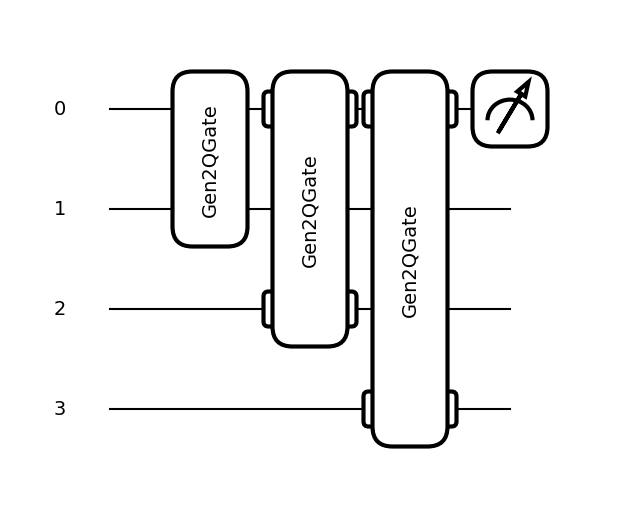

In [6]:
weights = np.random.uniform(0, 4 * np.pi, (3, 15))
qml.draw_mpl(qml_circuit)(weights);

In [15]:
bloch_vec = []
for _ in range(1000):
    weights = np.random.uniform(0, 4 * np.pi, (3, 15))
    bloch_vec.append(qml_circuit(weights))

bloch_vec = np.array(bloch_vec)
purities = (1. + np.sum(bloch_vec ** 2., axis=1)) / 2.

In [16]:
[purities.mean(), purities.std()]

[0.730773686, 0.12341692315089291]

In [17]:
# target
Avg1stFP(2, 2, 3)

0.688

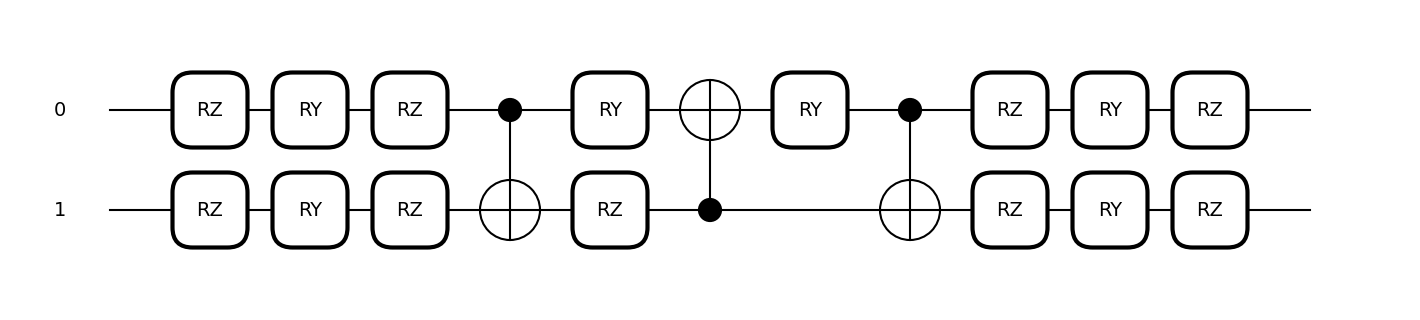

In [18]:
# for plot use
@qml.qnode(dev)
def gen2layer(weights):
    qml.RZ(weights[0], wires=0)
    qml.RY(weights[1], wires=0)
    qml.RZ(weights[2], wires=0)

    qml.RZ(weights[3], wires=1)
    qml.RY(weights[4], wires=1)
    qml.RZ(weights[5], wires=1)

    qml.CNOT(wires=[0, 1])

    qml.RY(weights[6], wires=0)
    qml.RZ(weights[7], wires=1)

    qml.CNOT(wires=[1, 0])

    qml.RY(weights[8], wires=0)

    qml.CNOT(wires=[0, 1])

    qml.RZ(weights[9], wires=0)
    qml.RY(weights[10], wires=0)
    qml.RZ(weights[11], wires=0)

    qml.RZ(weights[12], wires=1)
    qml.RY(weights[13], wires=1)
    qml.RZ(weights[14], wires=1)

    return 0


weights = np.random.uniform(-np.pi, np.pi, (15))
qml.draw_mpl(gen2layer)(weights);

## 2 Qubits, HEA circuit

In [19]:
def get_purity(r_vals):
    return np.sum(np.array(r_vals) ** 2.) / 4.
    
def get_density(r_vals):
    paulis = [qml.Identity, qml.PauliX, qml.PauliY, qml.PauliZ]

    res = np.zeros(shape=(4, 4)).astype(complex)
    for i in range(4):
        for j in range(4):
            res += r_vals[i, j] * qml.matrix(paulis[i](0) @ paulis[j](1)).astype(complex)

    res /= 4.

    return res

In [20]:
n_wires = 5
dev = qml.device('default.qubit', wires=n_wires, shots=1000)

# noise_model = NoiseModel.from_backend(FakeAuckland())
# dev = qml.device("qiskit.aer", wires=n_wires, optimization_level=0, noise_model=noise_model, shots=1000)

In [21]:
def HEA_circuit(params_data, params_ancilla):
    paulis = [qml.Identity, qml.PauliX, qml.PauliY, qml.PauliZ]
    time, depth, _ = params_data.shape
    time -= 2  # ignore data qubit
    for t in range(time):
        for l in range(depth):
            qml.RY(params_data[t, l, 0], wires=0)
            qml.RZ(params_data[t, l, 1], wires=0)
            qml.RY(params_data[t, l, 2], wires=1)
            qml.RZ(params_data[t, l, 3], wires=1)
            qml.RY(params_ancilla[t, l, 0], wires=t + 2)
            qml.RZ(params_ancilla[t, l, 1], wires=t + 2)

            qml.CNOT(wires=[0, t + 2])
            qml.CNOT(wires=[1, t + 2])

    return [qml.expval(p(0) @ q(1)) for p in paulis for q in paulis]


qnode = qml.QNode(HEA_circuit, dev)

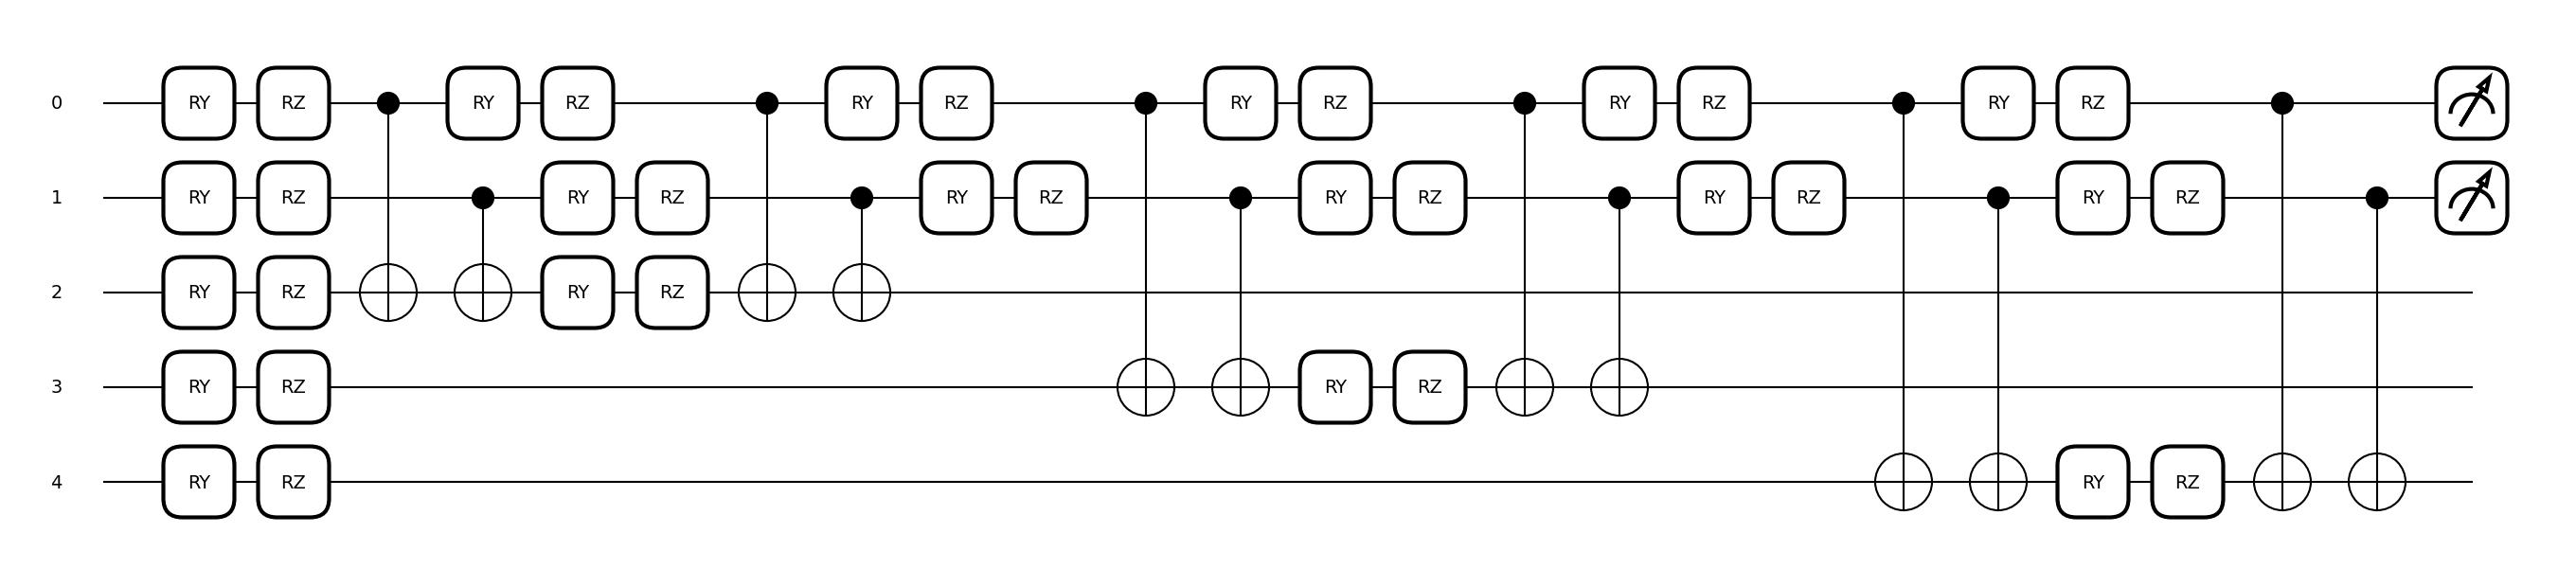

In [22]:
depth = 2
weights_data = np.random.uniform(0, 4. * np.pi, (n_wires, depth, 4))
weights_ancilla = np.random.uniform(0, 4. * np.pi, (n_wires, depth, 2))
qml.draw_mpl(qnode)(weights_data, weights_ancilla);

In [23]:
purities = []
for _ in range(1000):
    weights_data = np.random.uniform(0, 4. * np.pi, (n_wires, depth, 4))
    weights_ancilla = np.random.uniform(0, 4. * np.pi, (n_wires, depth, 2))
    r_vals = np.array(qnode(weights_data, weights_ancilla)).reshape(4, 4)
    purities.append(get_purity(r_vals))

purities = np.array(purities)

In [24]:
[purities.mean(), purities.std()]

[0.438766491, 0.08577237373442523]

In [26]:
# target
Avg1stFP(4, 2, n_wires - 2)

0.4323507180650038

## 2 Qubits, Noise Simulation

In [37]:
depth = 5
times = [1, 2, 3, 5, 8]
noise_model = NoiseModel.from_backend(FakeAuckland())

In [38]:
avg_purities = []
std_purities = []
true_purities = []
raw_purities = []
for t in times:
    n_wires = t + 2
    # dev = qml.device('default.qubit', wires=n_wires, shots=1000)
    dev = qml.device("qiskit.aer", wires=n_wires, optimization_level=0, noise_model=noise_model, shots=1000)
    qnode = qml.QNode(HEA_circuit, dev)

    purities = []
    for _ in range(500):
        weights_data = np.random.uniform(0, 4. * np.pi, (n_wires, depth, 4))
        weights_ancilla = np.random.uniform(0, 4. * np.pi, (n_wires, depth, 2))
        r_vals = np.array(qnode(weights_data, weights_ancilla)).reshape(4, 4)
        purities.append(get_purity(r_vals))

    purities = np.array(purities)
    
    raw_purities.append(purities)
    avg_purities.append(purities.mean())
    std_purities.append(purities.std())
    true_purities.append(Avg1stFP(4, 2, t))

In [39]:
raw_purities = np.array(raw_purities)
avg_purities = np.array(avg_purities)
std_purities = np.array(std_purities)
true_purities = np.array(true_purities)

In [40]:
[true_purities, avg_purities, std_purities]

[array([0.66666667, 0.50793651, 0.43235072, 0.37921785, 0.36531885]),
 array([0.59888991, 0.46804356, 0.39471804, 0.36022313, 0.3520312 ]),
 array([0.08217313, 0.07019867, 0.05049977, 0.04013371, 0.03724226])]

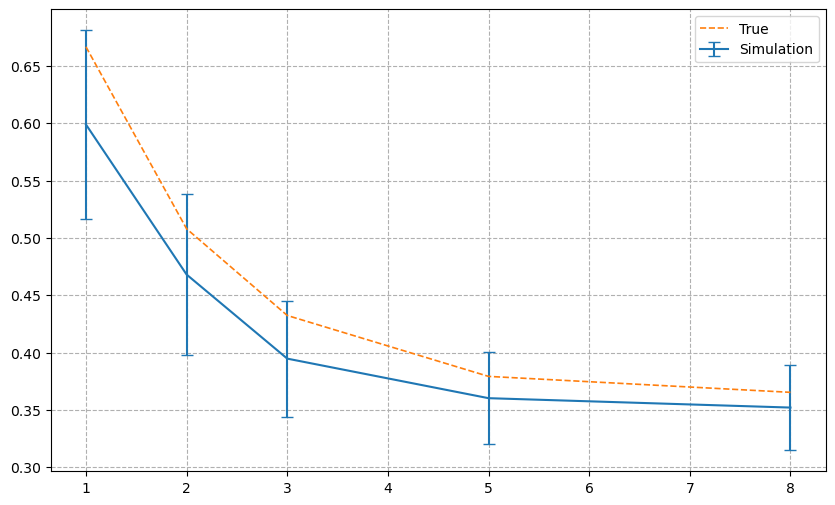

In [41]:
plt.figure(figsize=(10,6))
plt.errorbar(times, avg_purities, yerr=std_purities, label='Simulation', capsize=4)
plt.plot(times, true_purities, linewidth=1.2, linestyle='--', label='True')
plt.legend()
plt.grid(linestyle='--')

In [42]:
np.save("./noise_purity.npy", raw_purities)